<a href="https://colab.research.google.com/github/Arazsh/TensorFlow-in-Practice/blob/master/SignLanguageClassification_ImageAugmentaion_Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This is an example of multi-class classification using TensorFlow and CNN. The images, which are parts of the sign language dataset (https://www.kaggle.com/datamunge/sign-language-mnist/home) are presented in .CSV format, are used in this example. ImageDataGenerator and augmentation are used to reduce the overfitting problem.

In [ ]:
#importing the required libraries

import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

#Using callbacks to stop training after reaching to a certain accuracy
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end (self, epoch, logs ={}):
        if (logs.get('accuracy')>0.7):
            print("Reached 70% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallbacks()

Download the two 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv form  https://www.kaggle.com/datamunge/sign-language-mnist/home, and upload them to colab using the following botton.

In [ ]:
uploaded=files.upload()

Saving sign_mnist_test.csv to sign_mnist_test.csv
Saving sign_mnist_train.csv to sign_mnist_train.csv


In [ ]:
#This function is to read the .CSV files and convert them to train/test images.
#Each successive line contians 785 comma separated values between 0 and 255
#The first value is the label which is an integer between 0 and 24 (25 classes)
#The 784 pixel values (comma separated values) should be converted to 28*28 images

def get_data(filename):
    with open(filename) as training_file:
      reader = csv.reader(training_file, delimiter=',')    
      imgs = []
      labels = []

      next(reader, None)
        
      for row in reader:
          label = row[0]
          data = row[1:]
          img = np.array(data).reshape((28, 28))

          imgs.append(img)
          labels.append(label)

      images = np.array(imgs).astype(float)
      labels = np.array(labels).astype(float)
    return images, labels


training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')


print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [ ]:
#This part of the code is used to add one more dimension to image data in order to create
#train/test sets using ImageDataGenerator

from tensorflow.keras import utils
print(testing_labels[1])

training_images = np.expand_dims(training_images,axis=3)
testing_images = np.expand_dims(testing_images,axis=3)
training_labels = utils.to_categorical(training_labels, num_classes=25)
testing_labels = utils.to_categorical(testing_labels, num_classes=25)
#print(testing_labels.shape,testing_labels[1,:])
#print(training_images.shape)
#print(training_labels.shape)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
                                   rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_datagen.fit(training_images)
train_generator=train_datagen.flow(training_images, training_labels, batch_size=32)

  
    

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen.fit(testing_images)
validation_generator=validation_datagen.flow(testing_images, testing_labels, batch_size=32)
    
    

print(training_images.shape)
print(testing_images.shape)
    
# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

5.0
(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [ ]:
# Defining a model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation='softmax')
    # Your Code Here
])
model.summary()
# Compile Model. 
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the Model
history = model.fit_generator(train_generator, epochs=10, 
                              validation_data = validation_generator, verbose = 1, callbacks=[callbacks]
)
model.evaluate(testing_images, testing_labels)
    



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

[244.11962890625, 0.5235638618469238]

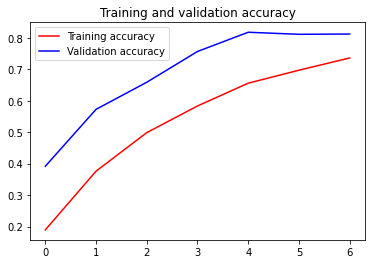

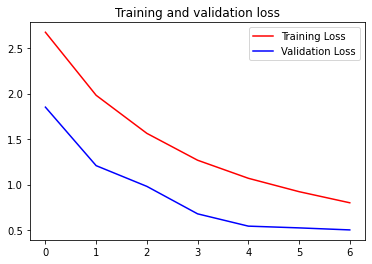

In [ ]:
# Plotting accuracy and loss on both training and validation VS epochs

import matplotlib.pyplot as plt
acc = history.history['accuracy']# Your Code Here
val_acc = history.history['val_accuracy']# Your Code Here
loss = history.history['loss']# Your Code Here
val_loss = history.history['val_loss']# Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()